In [1]:
import pandas as pd
import os

In [2]:
data_schema = pd.read_csv('./TC_ELCTY_ATMBL_ELCTC_RECD_20230609095252_schema.csv', encoding='euc-kr')
data_schema

,영문 컬럼명,한글 컬럼명,컬럼 타입,컬럼 길이,NULL 여부
0,ELCTC_DTM,충전_일시,VARCHAR2,19.0,True
1,CHRSTN_ID,충전소_ID,VARCHAR2,20.0,True
2,CHRGR_ID,충전기_ID,VARCHAR2,20.0,True
3,CTPR_CD,시도_코드,VARCHAR,10.0,True
4,SIGNGU_CD,시군구_코드,VARCHAR,5.0,True
5,CTPR_NM,시도_명,VARCHAR2,50.0,True
6,SIGNGU_NM,시군구_명,VARCHAR2,50.0,True
7,CHRSTN_NM,충전소_명,VARCHAR2,50.0,True
8,LA,위도,NUMBER,1310.0,False
9,LO,경도,NUMBER,1310.0,False


In [3]:
# 충전기ID, 시작일시, 종료일시, 전력사용량만 활용한다
# 충전기ID 별로 데이터를 정리한다
# 충전 속도는 일정하다고 가정한다
# 충전을 1시 30분부터 2시 30분까지 했다면 충전량을 30:30으로 나눠서 1시 데이터에 누적, 2시데이터에 누적한다
# 데이터를 기록한 총 날수로 나눠서 각 충전기ID의 시간별 충전량 평균치를 구한다
# 이 값으로 어떻게든 클러스터링 한다

In [4]:
path = "./TC_ELCTY_ATMBL_ELCTC_RECD_20230609095252/"
file_list = os.listdir(path)

In [5]:
data = []
for file_name in file_list:
    file_path = path + file_name
    data.append(pd.read_csv(file_path)[['충전기_ID', '시작_일시', '종료_일시', '전력_사용량']])

data = pd.concat(data, ignore_index=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094788 entries, 0 to 11094787
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   충전기_ID  object
 1   시작_일시   object
 2   종료_일시   object
 3   전력_사용량  int64 
dtypes: int64(1), object(3)
memory usage: 338.6+ MB


In [8]:
data.head(1)

,충전기_ID,시작_일시,종료_일시,전력_사용량
0,KRPPKCP0002,2022-12-31 22:12:28,2023-01-01 00:00:00,140


In [16]:
start_time = data.loc[:,'시작_일시']
end_time = data.loc[:,'종료_일시']

In [17]:
print(min(min(start_time), min(end_time)))
print(max(max(start_time), max(end_time)))

2022-12-31 22:12:28
2023-04-01 01:35:09


In [9]:
from datetime import datetime, timedelta

In [19]:
start_time_str = data.loc[0,'시작_일시']  
start_time_obj = datetime.strptime(start_time_str, '%Y-%m-%d %H:%M:%S')

end_time_str = data.loc[0,'종료_일시']  
end_time_obj = datetime.strptime(end_time_str, '%Y-%m-%d %H:%M:%S')

In [21]:
(end_time_obj - start_time_obj).seconds

6452

In [36]:
# start_time_obj.hour
test = start_time_obj.replace(minute=0,second=0)
start_time_obj, test

(datetime.datetime(2022, 12, 31, 22, 12, 28),
 datetime.datetime(2022, 12, 31, 22, 0))

C:\Users\user\miniconda3\envs\ecc\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


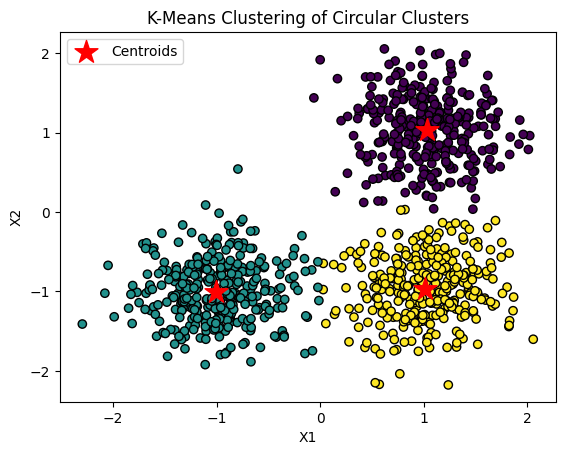

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# 원형 클러스터를 가진 데이터 생성
n_samples = 1000
centers = [[-1, -1], [1, 1], [1, -1]]
cluster_std = 0.4

X, _ = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=42)

# K-Means 클러스터링
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

# 클러스터링 결과
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# 클러스터링 결과 시각화
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300, c='red', label='Centroids')
plt.legend()
plt.title('K-Means Clustering of Circular Clusters')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()
